# BertEncoder 성능 평가

In [5]:
from bert_feature.bert_encoder import BertFeatureExtractor
from tqdm import tqdm

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import json

class G2PDataset(Dataset):
    def __init__(self, json_data, tokenizer, max_length=256):
        self.data = json_data["data"]
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        g2p_candidates = item["g2p_result"]
        target_sentence = item["sentence"]  # sentence is a list with 1 string


        return {
            
        }

def get_dataloader(json_path, tokenizer, batch_size=8, shuffle=True):
    with open(json_path, "r", encoding="utf-8") as f:
        json_data = json.load(f)
    dataset = G2PDataset(json_data, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [7]:
bert_encoder = BertFeatureExtractor()

Using device: cuda


In [ ]:
dataloader = get_dataloader(
    '/home/eden/Documents/JNU/2025-1/Natural-Language-Processing/Natural-Language-Processing-Project/data/001.문서요약/1.Training_1216_add/Train_법률_data/train_original_preprocessed.json',
    bert_encoder.tokenizer,
    batch_size=1,
    shuffle=True,
    
)

In [ ]:
json_path = '/home/eden/Documents/JNU/2025-1/Natural-Language-Processing/Natural-Language-Processing-Project/data/001.문서요약/1.Training_1216_add/Train_법률_data/train_original_preprocessed.json'
with open(json_path, "r", encoding="utf-8") as f:
        json_data = json.load(f)

In [ ]:
all_similarities = []
to_get_similarities = json_data["data"][:20]  # Limit to 1000 samples for testing

g2p_vectors = []
target_vectors = []

for data in tqdm(to_get_similarities):
    g2p_candidates = data["g2p_result"]
    target_sentence = data["sentence"]  # sentence is a list with 1 string
    g2p_embedding = bert_encoder.extract_features(g2p_candidates, pooling_strategy='cls')
    target_embedding = bert_encoder.extract_features(target_sentence, pooling_strategy='cls')

    g2p_vectors.append(g2p_embedding.cpu().numpy())
    target_vectors.append(target_embedding)

    similarities = torch.tensor([torch.cosine_similarity(g2p_embedding, target_embedding).item() for g2p_embedding in g2p_embedding])
    all_similarities.append(similarities.mean())
    


100%|██████████| 20/20 [00:00<00:00, 94.95it/s]


In [ ]:
print(g2p_vectors[0].shape)
print(target_vectors[0].shape)

(5, 768)
torch.Size([1, 768])


In [ ]:
target_vectors = torch.cat(target_vectors, dim=0)
print(target_vectors.shape)

torch.Size([20, 768])


In [ ]:
all_similarities = torch.stack(all_similarities)
print(all_similarities.shape)
print(all_similarities.mean())


torch.Size([20])
tensor(0.9648)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def visualize_all_in_one(ground_truths, samples):
    assert len(ground_truths) == len(samples)
    N = len(ground_truths)

    # 전체 포인트와 색상 라벨을 모음
    all_vectors = []
    labels = []  # 0 ~ N-1 : 어떤 정답에 속하는 샘플인지

    for i in range(N):
        all_vectors.append(ground_truths[i])  # (784,)
        labels.append(i)  # Ground truth도 label 필요

        for sample in samples[i]:  # Mᵢ개
            all_vectors.append(sample)
            labels.append(i)

    all_vectors = np.stack(all_vectors)  # (N + ΣMᵢ, 784)

    # 차원 축소
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    reduced = tsne.fit_transform(all_vectors)

    # 색 팔레트
    colors = cm.get_cmap('tab10', N)

    # 시각화
    plt.figure(figsize=(8, 8))
    plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts
    plt.rcParams['ps.fonttype'] = 42   # For EPS output


    idx = 0
    for i in range(N):
        gt_coord = reduced[idx]
        num_samples = len(samples[i])
        sample_coords = reduced[idx + 1: idx + 1 + num_samples]

        # 정답 벡터 (별표)
        plt.scatter(gt_coord[0], gt_coord[1], color=colors(i), marker='*', s=200, label=f'Target {i}')

        # 샘플 벡터들 (점)
        plt.scatter(sample_coords[:, 0], sample_coords[:, 1], color=colors(i), marker='o', s=70, alpha=0.7)

        # 연결선
        for sc in sample_coords:
            plt.plot([gt_coord[0], sc[0]], [gt_coord[1], sc[1]], color=colors(i), alpha=0.4, linestyle='--')

        idx += 1 + num_samples

    plt.title("t-SNE Visualization of Text Embeddings")
    plt.axis('off')
    plt.legend()
    plt.tight_layout()
    plt.savefig("./Progress/figures/tsne_text_embeddings.pdf", format='pdf')
    plt.savefig("./Progress/figures/tsne_text_embeddings.svg", format='svg')
    

    plt.show()


/tmp/ipykernel_2985821/3470867156.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', N)


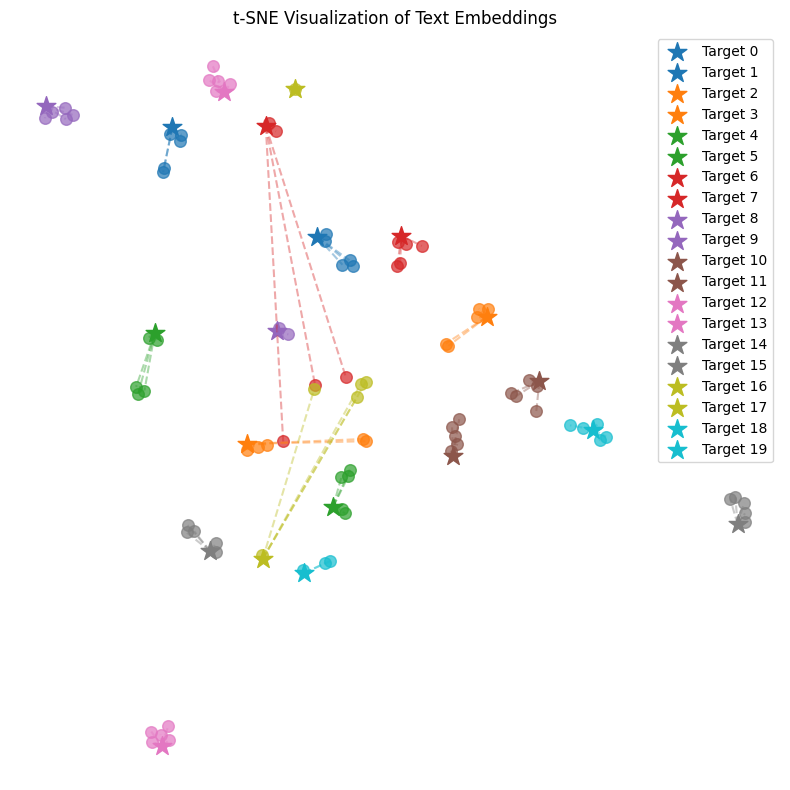

In [ ]:
visualize_all_in_one(target_vectors.cpu().numpy(), g2p_vectors)

/tmp/ipykernel_2985821/804016702.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', N)


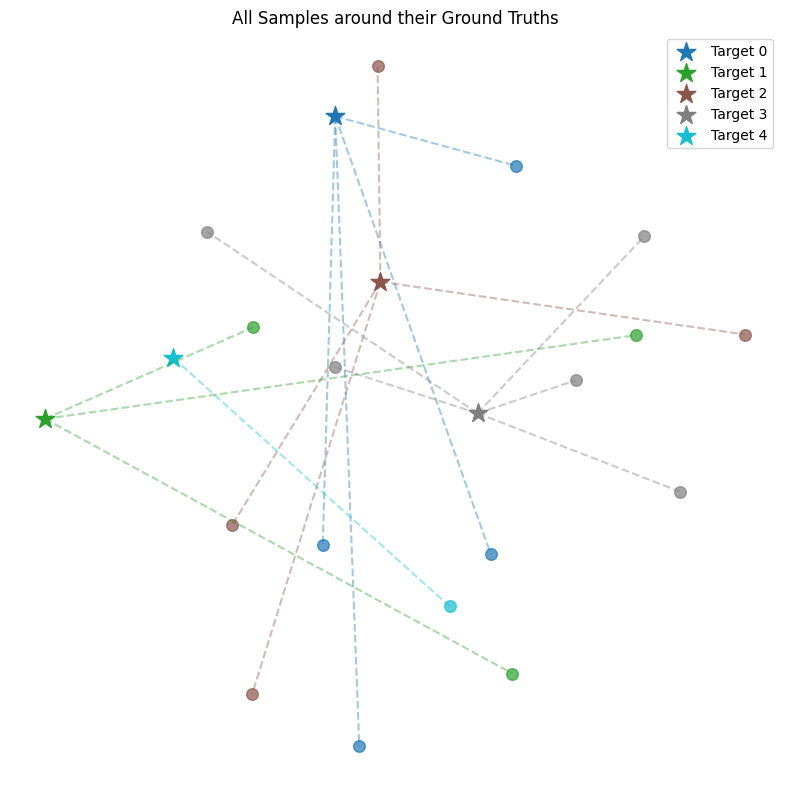

In [ ]:
# 예시 데이터
N = 5
ground_truths = np.random.rand(N, 784)
samples = [np.random.rand(np.random.randint(1, 6), 784) for _ in range(N)]

visualize_all_in_one(ground_truths, samples)


# FusionEmbedding 성능 평가

In [ ]:
for batch in dataloader:
    print(batch)
    g2p_mean_embedding = bert_encoder.extract_features(batch, pooling_strategy="mean")


    similarities = [torch.cosine_similarity(bert_encoder[0], bert_encoder[i]) for i in range(1, len(batch["g2p_results"]))]


[('타인의 등록상표와 동일 또는 유사한 표장을 이용한 경우라고 하더라도 그것이 상표의 본질적인 기능이라고 할 수 있는 출처표시를 위한 것이 아니라 순전히 디자인적으로만 사용되는 등으로 상표의 사용으로 인식될 수 없는 경우에는 등록상표의 상표권을 침해한 행위로 볼 수 없고,',), ('타인의 등록쌍표와 동일 또는 유사한 표장을 이용한 경우라고 하더라도 그것이 상표의 본질적인 기능이라고 할 쑤 있는 출처표시를 위한 것이 아니라 순전히 디자인적으로만 사용되는 등으로 상표의 사용으로 인식될 쑤 없는 경우에는 등록쌍표의 상표권을 침해한 행위로 볼 쑤 없고,',), ('타이늬 등록상표와 동일 또는 유사한 표장을 이용한 경우라고 하더라도 그거시 상표의 본질저긴 기능이라고 할 쑤 인는 출처표시를 위한 거시 아니라 순전히 디자인저그로만 사용되는 등으로 상표의 사용으로 인식될 쑤 없는 경우에는 등록상표의 상표궈늘 침해한 행위로 볼 쑤 없고,',), ('타이늬 등록쌍표와 동일 또느 뉴사한 표장으 리용한 경우라고 하더라도 그거시 상표의 본질저긴 기능이라고 할 쑤 있는 출처표시르 뤼한 거시 아니라 순전히 디자인저그로만 사용되는 등으로 상표의 사용으로 인식될 쑤 없는 경우에는 등록쌍표의 상표궈늘 침해한 행위로 볼 쑤 없고,',), ('타인의 등록쌍표와 동일 또느 뉴사한 표장으 리용한 경우라고 하더라도 그것이 상표의 본질적인 기능이라고 할 쑤 있는 출처표시르 뤼한 것이 아니라 순전히 디자인적으로만 사용되는 등으로 상표의 사용으로 인식될 쑤 없는 경우에는 등록쌍표의 상표권을 침해한 행위로 볼 쑤 없고,',), ('타이늬 등록상표와 동일 또느 뉴사한 표장으 리용한 경우라고 하더라도 그거시 상표의 본질저긴 기능이라고 할 수 있는 출처표시르 뤼한 거시 아니라 순전히 디자인저그로만 사용되는 등으로 상표의 사용으로 인식뙬 수 없는 경우에는 등록상표의 상표궈늘 침해한 행위로 볼 수 없고,',)]


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
from espnet2.bin.tts_inference import Text2Speech

model = Text2Speech.from_pretrained("imdanboy/kss_tts_train_jets_raw_phn_korean_cleaner_korean_jaso_train.total_count.ave")

speech, *_ = model("가나다라")

Failed to import Flash Attention, using ESPnet default: No module named 'flash_attn'


Fetching 36 files: 100%|██████████| 36/36 [00:00<00:00, 408094.44it/s]
/home/eden/anaconda3/envs/nlp2/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
 - discriminator_params.follow_official_norm
 - discriminator_params.scale_discriminator_params.use_weight_norm
 - discriminator_params.scale_discriminator_params.use_spectral_norm

See also:
 - https://github.com/espnet/espnet/pull/5240
 - https://github.com/espnet/espnet/pull/5249


In [ ]:
print(speech)

wav


In [ ]:
import soundfile as sf
sf.write("output.wav", speech.cpu().numpy(), model.fs)

AttributeError: 'str' object has no attribute 'cpu'

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline
import numpy as np

pipe = pipeline("text-to-speech", model="facebook/mms-tts-kor")

Device set to use cuda:0


In [ ]:
test_text = "안녕하세요."
# output = pipe(test_text)

output = pipe(test_text)['audio']

import scipy

scipy.io.wavfile.write("techno.wav", rate=pipe.model.config.sampling_rate, data=output)


error: ushort format requires 0 <= number <= (0x7fff * 2 + 1)

In [ ]:
from transformers import VitsModel, AutoTokenizer
import torch
import uroman as ur

model = VitsModel.from_pretrained("facebook/mms-tts-kor")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-kor")

uroman = ur.Uroman()

text = uroman.romanize_string("안녕하세요. 반갑습니다.", lang="ko", to="latin")
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs).waveform


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [ ]:
import scipy

scipy.io.wavfile.write("techno.wav", rate=model.config.sampling_rate, data=output.cpu().float().numpy().T)


In [ ]:
from IPython.display import Audio

Audio(output, rate=model.config.sampling_rate)


In [ ]:
from IPython.display import Audio

Audio(output, rate=model.config.sampling_rate)

TypeError: float() argument must be a string or a real number, not 'VitsModelOutput'

In [ ]:
from transformers import VitsModel, AutoTokenizer
import torch
import uroman as ur

model = VitsModel.from_pretrained("facebook/mms-tts-kor")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-kor")

uroman = ur.Uroman()

texts = ["안녕하세요.", "반갑습니다.", "오늘 날씨가 좋네요."]

# Romanize each text
romanized_texts = [uroman.romanize_string(t, lang="ko", to="latin") for t in texts]

# Tokenize as a batch
inputs = tokenizer(romanized_texts, return_tensors="pt", padding=True)

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# waveforms: Tensor of shape [batch_size, waveform_length]
waveforms = outputs.waveform

# Example: Access waveform for second input sentence
waveform_1 = waveforms[1]


In [ ]:
import scipy

scipy.io.wavfile.write("techno.wav", rate=model.config.sampling_rate, data=waveform_1.cpu().float().numpy().T)


In [ ]:
import os

print(len(os.listdir('/home/eden/Documents/JNU/2025-1/Natural-Language-Processing/Natural-Language-Processing-Project/data/tts_outputs_test/wav')))
print(len(os.listdir('/home/eden/Documents/JNU/2025-1/Natural-Language-Processing/Natural-Language-Processing-Project/data/tts_outputs_test/mp3')))


15970
8969


In [ ]:
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch, torchaudio
import torch.nn.functional as F

audio_model='facebook/wav2vec2-base-960h'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

wav_processor = Wav2Vec2Processor.from_pretrained(audio_model)
wav_model = Wav2Vec2Model.from_pretrained(audio_model).to(device)

def extract_features(waveforms):
    # waveforms = []
    # for wav_path in wav_paths:
    #     waveform, sample_rate = torchaudio.load(wav_path)

    #     if sample_rate != 16000:
    #         resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    #         waveform = resampler(waveform)

    #     waveforms.append(waveform.squeeze(0))  # [1, T] → [T]

    max_len = max(waveform.shape[0] for waveform in waveforms)

    padded_waveforms = [F.pad(waveform, (0, max_len - waveform.shape[0]), value=0) for waveform in waveforms]
    padded_waveforms = torch.stack(padded_waveforms)  # [batch_size, T]

    # 가장 긴 waveform 기준으로 padding 처리
    inputs = wav_processor(padded_waveforms, sampling_rate=16000, return_tensors='pt', padding=True).to(wav_model.device)['input_values']
    inputs = inputs.squeeze(0).squeeze(0)
    # print(inputs.shape)  # [batch_size, T]

    # print(inputs)
    # raise

    with torch.no_grad():
        outputs = wav_model(inputs)

    return outputs.last_hidden_state.mean(dim=1)  # [batch_size, 768]


/home/eden/anaconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import VitsModel, AutoTokenizer
import uroman as ur

model = VitsModel.from_pretrained("facebook/mms-tts-kor").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-kor")
@torch.no_grad()
def make_tts_outputs(texts:str):
    uroman = ur.Uroman()

    romanized_texts = [uroman.romanize_string(t, lang="ko", to="latin") for t in texts]
    inputs = tokenizer(romanized_texts, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
    with torch.no_grad():
        output = model(**inputs).waveform

    return output

In [ ]:
import json
import pandas as pd
from tqdm import tqdm



json_file_list = os.listdir("/home/chaewon215/chbf/PatternSVG/temp/Natural-Language-Processing-Project/data/12.한영말뭉치")
json_dir_list = [os.path.join("/home/chaewon215/chbf/PatternSVG/temp/Natural-Language-Processing-Project/data/12.한영말뭉치", file) for file in json_file_list if file.endswith("preprocessed.json")]

# # JSON 데이터 로드
# with open("/home/chaewon215/chbf/PatternSVG/temp/Natural-Language-Processing-Project/data/001.문서요약/1.Training_1216_add/Train_법률_data/train_original_preprocessed.json", "r", encoding="utf-8") as f:
#     raw_data = json.load(f)["data"]

raw_data = []
for json_dir in json_dir_list:
    with open(json_dir, "r", encoding="utf-8") as f:
        data = json.load(f).get("data", [])
        raw_data.extend(data)

# 데이터의 5%만 사용
raw_data = raw_data[:(int(0.05 * len(raw_data)))]
# g2p_result 중 하나와 sentence를 매칭해서 여러 샘플 생성
pairs = []

wav_base_dir = "/home/eden/Documents/JNU/2025-1/Natural-Language-Processing/Natural-Language-Processing-Project/data/tts_outputs_test/wav"
wav_paths = []

batch_raw_data = [raw_data[i:i+4] for i in range(0, len(raw_data), 4)]

for batch in tqdm(batch_raw_data):
    batch_wav_texts = []
    for item in batch:
        correct = item["sentence"][0]
        batch_wav_texts.append(correct)  # 정답 문장 추가
        for g2p in item["g2p_result"]:
            batch_wav_texts.append(g2p)

    tts_outputs = make_tts_outputs(batch_wav_texts)
    features = extract_features(tts_outputs).to("cpu").tolist()

    feature_idx = 0

    for item in batch:
        correct = item["sentence"][0]
        g2p_len = len(item["g2p_result"])

        for g2p, phonetic_feature in zip(item["g2p_result"], features[feature_idx+1:g2p_len]):  # 첫 번째는 정답 문장
            pairs.append({"input": g2p, "target": correct, "input_wav": phonetic_feature, "target_wav": features[feature_idx]})
            
        feature_idx += g2p_len + 1  # +1은 정답 문장에 해당하는 feature
    

# batch_wav_paths = [wav_paths[i:i+16] for i in range(0, len(wav_paths), 16)]

# for batch in tqdm(batch_wav_paths):
#     features = extract_features(batch)
#     for i, wav_path in enumerate(batch):
#         pairs[i]["wav_path"] = wav_path
#         pairs[i]["embedding"] = features[i].cpu().numpy().tolist()  # numpy array를 list로 변환하여 JSON에 저장 가능하게 함
    

# train, validation, test 데이터로 나누기
import random
random.seed(42)
random.shuffle(pairs)
train_size = int(0.8 * len(pairs))
validation_size = int(0.1 * len(pairs))
test_size = len(pairs) - train_size - validation_size
train_pairs = pairs[:train_size]
validation_pairs = pairs[train_size:train_size + validation_size]
test_pairs = pairs[train_size + validation_size:]


# CSV로 저장
train_df = pd.DataFrame(train_pairs)
validation_df = pd.DataFrame(validation_pairs)
test_df = pd.DataFrame(test_pairs)

train_df.to_csv("train.csv", index=False)
validation_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)



  0%|          | 0/3022 [00:03<?, ?it/s]


AttributeError: 'list' object has no attribute 'cpu'

In [1]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

# 토크나이저 및 모델 로드
tokenizer = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-base-v2")
model = BartForConditionalGeneration.from_pretrained("gogamza/kobart-base-v2")

from datasets import load_dataset
import ast

dataset = load_dataset("csv", data_files={"train": "train.csv", "validation": "validation.csv"})

def preprocess_function(examples):
    inputs = tokenizer(examples["input"], max_length=256, truncation=True, padding="max_length")
    targets = tokenizer(examples["target"], max_length=256, truncation=True, padding="max_length")

    inputs["input_ids"] = inputs["input_ids"]
    inputs["labels"] = targets["input_ids"]
    inputs["input_wav"] = [ast.literal_eval(x) for x in examples["input_wav"]]
    inputs["target_wav"] = [ast.literal_eval(x) for x in examples["target_wav"]]

    return inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["input", "target"])

# tokenized_dataset을 저장
tokenized_dataset.save_to_disk("tokenized_dataset")



/home/eden/anaconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
Saving the dataset (1/1 shards): 100%|██████████| 4349/4349 [00:00<00:00, 117041.46 examples/s]


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./kobart-correction",
    eval_strategy="epoch",       # 'epoch' → 'steps'
    logging_strategy="steps",
    logging_steps=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=5e-5,
    logging_dir="./logs",
    save_strategy="epoch",            # 여전히 epoch마다 저장
    save_total_limit=2,
    report_to="wandb",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer
)

trainer.train()


/tmp/ipykernel_54160/4222560165.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: edenkim9741 (edenkim9741-chonnam-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.006900,0.004404
2,0.002200,0.002034
3,0.000800,0.001383
4,0.000300,0.001095
5,0.000200,0.001046


/home/eden/anaconda3/envs/nlp/lib/python3.12/site-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'forced_eos_token_id': 1}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=13735, training_loss=0.014269139044580782, metrics={'train_runtime': 5524.8104, 'train_samples_per_second': 39.769, 'train_steps_per_second': 2.486, 'total_flos': 3.34920614805504e+16, 'train_loss': 0.014269139044580782, 'epoch': 5.0})

In [2]:
import torch
import torch.nn as nn
from phonetic_feature.phonetic_encoder import PhoneticEncoder
from fusion_layer.FusionLayer import FeatureFusion
from decoder.TransformerDecoder import TransformerDecoder
from torch.utils.data import Dataset, DataLoader
import json
import os
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast


class PhoneticCorrectionModel(nn.Module):
    def __init__(self, phonetic_dim, hidden_dim):
        super().__init__()
        self.text_encoder = BartForConditionalGeneration.from_pretrained("gogamza/kobart-base-v2")
        self.phonetic_encoder = PhoneticEncoder(phonetic_dim, hidden_dim)       ## phonetic_dim: 입력 벡터 차원, hidden_dim: 모델 내부부의 hidden_state 차원
        self.tokenizer = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-base-v2")

        # 각 모델의 pretraining weight load
        vocab_size = self.tokenizer.vocab_size
        self.fusion = FeatureFusion(text_dim=768, phonetic_dim=hidden_dim * 2)
        self.decoder = TransformerDecoder(d_model=768, vocab_size=vocab_size)

    def forward(self, input_ids, attention_mask, phonetic_features, tgt_input):
        text_feat = self.text_encoder(input_ids, attention_mask)
        phonetic_feat = self.phonetic_encoder(phonetic_features)
        # print(text_feat.keys())
        attention_mask = attention_mask.unsqueeze(-1)
        sum_hidden_state = torch.mean(text_feat['encoder_last_hidden_state'] * attention_mask, dim=1)  # [batch_size, hidden_dim
        print(f"sum_hidden_state shape: {sum_hidden_state.shape}, phonetic_feat shape: {phonetic_feat.shape}")
        
        fused = self.fusion(sum_hidden_state, phonetic_feat)

        output = self.decoder(tgt_input, memory=fused)
        return output

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
phonetic_model = PhoneticCorrectionModel(phonetic_dim=768, hidden_dim=512).to(device)
from torch.optim import AdamW
optimizer = AdamW(phonetic_model.parameters(), lr=5e-5)
from torch.utils.data import DataLoader

train_dataset = tokenized_dataset["train"]
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
from tqdm import tqdm
for epoch in range(5):
    phonetic_model.train()
    for batch in tqdm(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        phonetic_features = batch["phonetic_features"].to(device)  # Assuming embedding is already a tensor
        tgt_input = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = phonetic_model(input_ids, attention_mask, phonetic_features, tgt_input)
        loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), tgt_input.view(-1), ignore_index=-100)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


NameError: name 'PhoneticCorrectionModel' is not defined

In [1]:
import torch
import torch.nn as nn
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

# 저장된 tokenized_dataset을 불러오기
from datasets import load_from_disk
tokenized_dataset = load_from_disk("tokenized_dataset")

class CustomBartWithFusion(nn.Module):
    def __init__(self, bart_model_name="gogamza/kobart-base-v2"):
        super().__init__()
        self.model = BartForConditionalGeneration.from_pretrained(bart_model_name)

        # Fusion Layer: [text_feat; phonetic_feat] → hidden_dim
        self.fusion = nn.Linear(768 + 768, 768)  # 고정 크기 가정 (BART hidden size = 768)

    def forward(self, input_ids, attention_mask, decoder_input_ids, decoder_attention_mask, phonetic_feat):
        # 1. BART Encoder
        encoder_outputs = self.model.model.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )  # encoder_outputs.last_hidden_state: [B, T, 768]

        # 2. 평균을 내서 [B, 768] text_feature 추출 (또는 첫 토큰을 쓸 수도 있음)
        text_feat = (encoder_outputs.last_hidden_state * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)

        # 3. Fusion: [text_feat; phonetic_feat] → [B, 768]
        fused_feat = self.fusion(torch.cat([text_feat, phonetic_feat], dim=-1))  # [B, 768]

        # 4. BART decoder는 encoder_hidden_states가 [B, T, 768]이길 기대하므로 repeat
        batch_size, seq_len = encoder_outputs.last_hidden_state.size(0), encoder_outputs.last_hidden_state.size(1)
        fused_encoder_hidden = fused_feat.unsqueeze(1).repeat(1, seq_len, 1)  # [B, T, 768]

        # 5. Decoder
        decoder_outputs = self.model.model.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=fused_encoder_hidden,
            encoder_attention_mask=attention_mask  # 그대로 사용 가능
        )

        # 6. Language modeling head
        lm_logits = self.model.lm_head(decoder_outputs.last_hidden_state)

        return lm_logits


/home/eden/anaconda3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torch.nn.utils.rnn import pad_sequence
import torch

tokenizer = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-base-v2")

def collate_fn(batch):
    input_ids = [torch.tensor(example['input_ids']) for example in batch]
    attention_mask = [torch.tensor(example['attention_mask']) for example in batch]
    labels = [torch.tensor(example['labels']) for example in batch]
    phonetic_features = [torch.tensor(example['input_wav']) for example in batch]


    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    # BART의 labels는 -100으로 마스킹해야 loss에서 무시됨
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        'input_ids': input_ids,  # [batch_size, seq_length]
        'attention_mask': attention_mask,
        'labels': labels,
        'phonetic_features': torch.stack(phonetic_features, dim=0)  # [batch_size, phonetic_dim]
    }


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
phonetic_model = CustomBartWithFusion().to(device)
from torch.optim import AdamW
optimizer = AdamW(phonetic_model.parameters(), lr=5e-5)
from torch.utils.data import DataLoader
from torch.nn import functional as F

train_dataset = tokenized_dataset["train"]
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
from tqdm import tqdm
for epoch in range(5):
    phonetic_model.train()
    bar = tqdm(train_dataloader)
    for batch in bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        phonetic_features = batch["phonetic_features"].to(device)  # Assuming embedding is already a tensor
        tgt_input = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = phonetic_model(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            decoder_input_ids=tgt_input, 
            decoder_attention_mask=(tgt_input != tokenizer.pad_token_id).long(),
            phonetic_feat=phonetic_features)
        loss = F.cross_entropy(outputs.view(-1, outputs.size(-1)), tgt_input.view(-1), ignore_index=-100)
        bar.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

        

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
  1%|▏         | 28/2175 [00:11<14:40,  2.44it/s]


KeyboardInterrupt: 

In [19]:
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch, torchaudio
import torch.nn.functional as F
import os

audio_model='facebook/wav2vec2-base-960h'

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

wav_processor = Wav2Vec2Processor.from_pretrained(audio_model)
wav_model = Wav2Vec2Model.from_pretrained(audio_model).to(device0).eval()

# from transformers import WhisperProcessor, WhisperModel

# wav_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
# wav_model = WhisperModel.from_pretrained("openai/whisper-small").to(device).eval()

# # Load model directly
# from transformers import AutoProcessor, AutoModel

# wav_processor = AutoProcessor.from_pretrained("ntu-spml/distilhubert")
# wav_model = AutoModel.from_pretrained("ntu-spml/distilhubert")

@torch.no_grad()
def extract_features(waveforms):

    max_len = max(waveform.shape[0] for waveform in waveforms)

    padded_waveforms = [F.pad(waveform, (0, max_len - waveform.shape[0]), value=0).numpy() for waveform in waveforms.cpu()]
    # padded_waveforms = torch.stack(padded_waveforms).to("cpu")  # [batch_size, T]
    # print(f"Padded waveforms shape: {padded_waveforms.shape}")

    # 가장 긴 waveform 기준으로 padding 처리
    inputs = wav_processor(padded_waveforms, sampling_rate=16000, return_tensors='pt', padding=True)['input_values'].to(device0)  # [batch_size, T]
    
    inputs = inputs.squeeze(0).squeeze(0)
    outputs = wav_model(inputs)

    return outputs.last_hidden_state.mean(dim=1)  # [batch_size, 768]

from transformers import VitsModel, AutoTokenizer
import uroman as ur

model = VitsModel.from_pretrained("facebook/mms-tts-kor").to(device1).eval()
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-kor")

@torch.no_grad()
def make_tts_outputs(inputs):
    
    output = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"]).waveform

    return output

import json
import pandas as pd
from tqdm import tqdm



json_file_list = os.listdir("/home/chaewon215/chbf/PatternSVG/temp/Natural-Language-Processing-Project/data/12.한영말뭉치")
json_dir_list = [os.path.join("/home/chaewon215/chbf/PatternSVG/temp/Natural-Language-Processing-Project/data/12.한영말뭉치", file) for file in json_file_list if file.endswith("preprocessed.json")]

# # JSON 데이터 로드
# with open("/home/chaewon215/chbf/PatternSVG/temp/Natural-Language-Processing-Project/data/001.문서요약/1.Training_1216_add/Train_법률_data/train_original_preprocessed.json", "r", encoding="utf-8") as f:
#     raw_data = json.load(f)["data"]

raw_data = []
for json_dir in json_dir_list:
    with open(json_dir, "r", encoding="utf-8") as f:
        data = json.load(f).get("data", [])
        raw_data.extend(data)


# 데이터의 5%만 사용
raw_data = raw_data[:(int(0.1 * len(raw_data)))]

# g2p_result 중 하나와 sentence를 매칭해서 여러 샘플 생성
pairs = []

batch_size = 16
# batch_raw_data = [raw_data[i:i+batch_size] for i in range(0, len(raw_data), batch_size)]
# uroman = ur.Uroman()


from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from functools import partial

# 1. 평탄화된 g2p 전체 리스트 구성
all_g2ps = [g2p for entry in raw_data for g2p in entry["g2p_result"]]

# def init_uroman():
#     global _uroman
#     _uroman = ur.Uroman()

# def romanize_truncated(g2p, max_char_length=512):
#     global _uroman
#     return _uroman.romanize_string(g2p[:max_char_length], lang="ko", to="latin")


# num_workers = cpu_count()  # or manually set like 4, 8, etc.
# with Pool(processes=num_workers, initializer=init_uroman) as pool:
#     g2p_texts = list(tqdm(pool.imap(romanize_truncated, all_g2ps), total=len(all_g2ps)))


# # print(g2p_texts[:10])  # 확인용 출력

# from datasets import Dataset

# # 1. 리스트 → Dataset 객체로 변환
# g2p_dataset = Dataset.from_dict({"text": g2p_texts})


# print(f"Dataset size: {len(g2p_dataset)}")

# def preprocess_function(examples):
#     inputs = tokenizer(examples["text"], max_length=256, truncation=True, padding="max_length", return_tensors="pt")
#     return inputs

# batch_encoding = g2p_dataset.map(preprocess_function, batched=True, num_proc=cpu_count(), batch_size=1024)

# # batch_encoding 저장
# batch_encoding.save_to_disk("g2p_dataset")

# batch_encoding 불러오기
from datasets import load_from_disk
batch_encoding = load_from_disk("Dataset/g2p_dataset")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
batch_encoding = batch_encoding.remove_columns("text")

In [21]:
batch_encoding.column_names

['input_ids', 'attention_mask']

In [22]:
# batch_encoding 불러오기
from datasets import load_from_disk, Dataset
from torch.utils.data import DataLoader
dataloader = DataLoader(batch_encoding, batch_size=batch_size, shuffle=False)

In [26]:
wav_feature = []

import numpy as np

for batch in tqdm(dataloader, desc="Processing batches"):
    # batch_wav_texts = []
    # for item in batch:
    #     correct = item["sentence"][0]
    #     # batch_wav_texts.append(correct)  # 정답 문장 추가
    #     for g2p in item["g2p_result"]:
    #         batch_wav_texts.append(g2p)
    inputs = {
        "input_ids": torch.from_numpy(np.array(batch["input_ids"])).to(device1),
        "attention_mask": torch.from_numpy(np.array(batch["attention_mask"])).to(device1)
    }

    tts_outputs = make_tts_outputs(inputs).to(device1)
    features = extract_features(tts_outputs).to("cpu").tolist()
    
    wav_feature.extend(features)
    break

Processing batches:   0%|          | 0/39813 [00:01<?, ?it/s]


In [4]:
import torch
torch.load("model_epoch_5.pt").keys()

odict_keys(['model.final_logits_bias', 'model.model.shared.weight', 'model.model.encoder.embed_tokens.weight', 'model.model.encoder.embed_positions.weight', 'model.model.encoder.layers.0.self_attn.k_proj.weight', 'model.model.encoder.layers.0.self_attn.k_proj.bias', 'model.model.encoder.layers.0.self_attn.v_proj.weight', 'model.model.encoder.layers.0.self_attn.v_proj.bias', 'model.model.encoder.layers.0.self_attn.q_proj.weight', 'model.model.encoder.layers.0.self_attn.q_proj.bias', 'model.model.encoder.layers.0.self_attn.out_proj.weight', 'model.model.encoder.layers.0.self_attn.out_proj.bias', 'model.model.encoder.layers.0.self_attn_layer_norm.weight', 'model.model.encoder.layers.0.self_attn_layer_norm.bias', 'model.model.encoder.layers.0.fc1.weight', 'model.model.encoder.layers.0.fc1.bias', 'model.model.encoder.layers.0.fc2.weight', 'model.model.encoder.layers.0.fc2.bias', 'model.model.encoder.layers.0.final_layer_norm.weight', 'model.model.encoder.layers.0.final_layer_norm.bias', 'mo